# IndabaX Guinée 2025
# IA Générative : De la Théorie Fondamentale à l'Innovation Locale

**Présenté par : Dr. Mamadou Pathé LY & Kevin Belingar**

**Date : 10 & 11 Décembre 2025 | Conakry, CCFG**

---

##  Plan du Notebook

1. **Partie 1 : GANs (Generative Adversarial Networks)**
   - Fondements théoriques
   - Implémentation complète d'un GAN
   - Génération d'images synthétiques

2. **Partie 2 : Large Language Models (LLMs)**
   - Intégration des APIs (Claude & OpenAI)
   - Tests avec des langues locales africaines

3. **Partie 3 : RAG (Retrieval-Augmented Generation)**
   - Implémentation d'un système RAG
   - Vector database avec données synthétiques
   - Application au contexte guinéen

4. **Partie 4 : Perspectives**
   - Fine-tuning avec modèles open-source
   - Adaptation locale pour l'Afrique de l'Ouest

---

---

# PARTIE 1 : GANS (Generative Adversarial Networks)

## 1.1 Introduction aux GANs

Les **GANs** (Réseaux Antagonistes Génératifs) sont une architecture d'apprentissage profond inventée par Ian Goodfellow en 2014.

### Architecture :
- **Générateur (G)** : Crée de fausses données à partir de bruit aléatoire
fig_generative.5f01c08f5208.avif
- **Discriminateur (D)** : Distingue les vraies données des fausses

fig_discriminative.9c22a1cd877d.avif
### Fonction objectif :

$$\min_G \max_D V(D,G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1-D(G(z)))]$$

---

## Installation et Importation

In [1]:
# Installation des dépendances
# !pip install torch torchvision matplotlib numpy tqdm -q

In [17]:
# Importations standards
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
# You’re going to need torchvision and transforms to obtain the training data and perform image conversions.

Set up the random generator seed to be able to replicate the experiment:

In [18]:
torch.manual_seed(111)

 Comme cet exemple utilise des images dans l’ensemble d’entraînement, les modèles doivent être plus complexes, avec un nombre de paramètres plus élevé. Cela rend le processus d’apprentissage plus lent, prenant environ deux minutes par époque lorsqu’il est exécuté sur un CPU. Il faut environ cinquante époques pour obtenir un résultat pertinent, ce qui porte le temps total d’entraînement à environ cent minutes sur un CPU.

Pour réduire ce temps d’entraînement, vous pouvez utiliser un GPU si vous en avez un à disposition. Cependant, il faudra déplacer manuellement les tenseurs et les modèles vers le GPU pour pouvoir les utiliser dans le processus d’apprentissage.

Vous pouvez vous assurer que votre code fonctionne dans les deux configurations en créant un objet *device* qui pointe soit vers le CPU, soit vers le GPU si l’un est disponible :

In [19]:
# Configuration du device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")

Device : cuda


## Preparing the Training Data


**« Le jeu de données MNIST est composé d’images en niveaux de gris de chiffres manuscrits, allant de 0 à 9, d’une résolution de 28 × 28 pixels. Pour les utiliser avec PyTorch, il est nécessaire d’effectuer certaines conversions. Pour cela, on définit *transform*, une fonction utilisée lors du chargement des données. »**


In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


**La fonction comporte deux parties :**

1. **`transforms.ToTensor()`** convertit les données en un tenseur PyTorch.
2. **`transforms.Normalize()`** ajuste l’échelle des coefficients du tenseur.


Vous pouvez maintenant charger les données d’entraînement en utilisant `torchvision.datasets.MNIST` et effectuer les conversions à l’aide de `transform`:

In [21]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

Maintenant que vous avez créé `train_set`, vous pouvez créer le chargeur de données :


In [22]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Matplotlib to plot some samples of the training data.

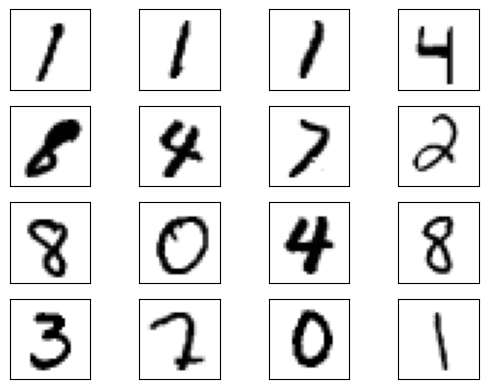

In [23]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## Implementation du Discriminator et du Generator


**« Dans ce cas, le discriminateur est un réseau neuronal MLP qui reçoit une image de 28 × 28 pixels et fournit la probabilité que cette image appartienne aux données réelles d’entraînement. »**


In [25]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024), # Le modèle reçoit en entrée une image 28 × 28 = 784 pixels, aplatie en un vecteur de taille 784.Cette couche projette ces 784 valeurs vers 1024 neurones.
            nn.ReLU(),
            nn.Dropout(0.3), # Le réseau comporte trois couches cachées, chacune suivie d’une fonction d’activation ReLU et d’un Dropout, utilisé pour éviter le surapprentissage.
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [26]:
discriminator = Discriminator().to(device=device)

« Comme le générateur va produire des données plus complexes, il est nécessaire d’augmenter la dimension de l’entrée provenant de l’espace latent. »

In [27]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [28]:
generator = Generator().to(device=device)

[ hyperbolic tangent function](http://mathworld.wolfram.com/HyperbolicTangent.html) as the activation of the output layer since the output coefficients should be in the interval from -1 to 1

## Training the Models


In [29]:
lr = 0.0001
num_epochs = 30
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

## The training loop

In [30]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Donnée pour entrainer le discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Entrainement du discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Donnees pour entrainer le generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5889771580696106
Epoch: 0 Loss G.: 0.4736277759075165
Epoch: 1 Loss D.: 0.028150778263807297
Epoch: 1 Loss G.: 5.334431171417236
Epoch: 2 Loss D.: 0.0006720678065903485
Epoch: 2 Loss G.: 12.967259407043457
Epoch: 3 Loss D.: 0.018401801586151123
Epoch: 3 Loss G.: 6.738242149353027
Epoch: 4 Loss D.: 0.013765417039394379
Epoch: 4 Loss G.: 5.320888996124268
Epoch: 5 Loss D.: 0.1826200932264328
Epoch: 5 Loss G.: 4.3525590896606445
Epoch: 6 Loss D.: 0.030330706387758255
Epoch: 6 Loss G.: 5.326847076416016
Epoch: 7 Loss D.: 0.09873221814632416
Epoch: 7 Loss G.: 4.248191833496094
Epoch: 8 Loss D.: 0.0036748142447322607
Epoch: 8 Loss G.: 9.374857902526855
Epoch: 9 Loss D.: 1.377788238926818e-15
Epoch: 9 Loss G.: 60.057830810546875
Epoch: 10 Loss D.: 0.0
Epoch: 10 Loss G.: 100.0
Epoch: 11 Loss D.: 9.821359019627348e-39
Epoch: 11 Loss G.: 100.0
Epoch: 12 Loss D.: 0.0
Epoch: 12 Loss G.: 100.0
Epoch: 13 Loss D.: 0.0
Epoch: 13 Loss G.: 100.0
Epoch: 14 Loss D.: 0.0
Epoch: 14 Loss 

Quelles sources pour plus:

[GANs in Action: Deep Learning with Generative Adversarial Networks](https://realpython.com/asins/1617295566/), by Jakub Langr and Vladimir Bok, covers the subject in much more detail, including recent applications such as CycleGAN for performing style transfers.

[Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play](https://realpython.com/asins/1492041947/), by David Foster, surveys practical applications of generative adversarial networks and other generative models.

[Ref](https://realpython.com/generative-adversarial-networks/) code sources

## Checking the Samples Generated by the GAN


In [31]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

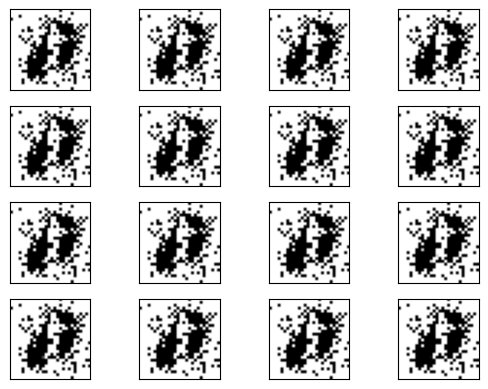

In [32]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Félicitations ! Vous avez appris à implémenter votre propre GAN.

---

# PARTIE 2 : LARGE LANGUAGE MODELS (LLMs)

## 2.1 Introduction aux LLMs

Les **LLMs** sont des modèles de deep learning entraînés sur d'énormes corpus de texte.

### Caractéristiques :
- Architecture Transformer
- Pré-entraînement massif
- Few-shot learning
- Support multilingue (limité pour langues africaines)

### Modèles utilisés :
- **GPT-4** (OpenAI)
- **Claude** (Anthropic)

---

## 2.2 Installation

In [42]:
# Installation des bibliothèques
!pip install openai anthropic deepseek python-dotenv huggingface_hub groq google-generativeai -q

In [43]:
# !pip install --upgrade openai

In [20]:
# Importations
import os
from openai import OpenAI
from groq import Groq
import google.generativeai as genai

## 2.3 Configuration des APIs

In [22]:
from google.colab import userdata
# userdata.get('')
# userdata.get('')

In [23]:
# Groq
groq_api_key = userdata.get('GROQ_API_KEY')
groq_client = Groq(api_key=groq_api_key)

[Groq API Key](https://console.groq.com/keys)

In [47]:
# OpenAI
openai_api_key = userdata.get('OPENAI_API_KEY')
openai_client = OpenAI(api_key=openai_api_key)

[OpenAI API Key](https://openai.com/api/)

In [48]:
# Gemini (Google) - Commenté si quota dépassé
# gemini_api_key = userdata.get('GEMINI_API_KEY')
# genai.configure(api_key=gemini_api_key)

[Gemini API Keys](https://aistudio.google.com/app/api-keys)

In [49]:
# Hugging Face (Alternative gratuite)
from huggingface_hub import InferenceClient
hf_token = userdata.get('HF_TOKEN')
hf_client = InferenceClient(token=hf_token)

[HuggenFace](https://huggingface.co/settings/tokens/new?ownUserPermissions=repo.content.read&ownUserPermissions=inference.serverless.write&canReadGatedRepos=true&tokenType=fineGrained)

## Fonctions de requête


In [24]:
def query_groq(prompt, model="llama-3.3-70b-versatile", temp=0.7, max_tok=500):
    """
    Envoie une requête au modèle Groq et retourne le texte généré.
    """
    try:
        resp = groq_client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=temp,
            max_tokens=max_tok
        )
        return resp.choices[0].message.content
    except Exception as e:
        return f"Erreur : {e}"

In [51]:
def query_openai(prompt, model="gpt-4o-mini", temp=0.7, max_tok=500):
    """
    Envoie une requête au modèle OpenAI et retourne le texte généré.
    """
    try:
        resp = openai_client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=temp,
            max_tokens=max_tok
        )
        return resp.choices[0].message.content
    except Exception as e:
        return f"Erreur : {e}"

In [52]:
def query_huggingface(prompt, model="meta-llama/Llama-3.2-3B-Instruct", temp=0.7, max_tok=500):
    """
    Envoie une requête à un modèle Hugging Face et retourne le texte généré.
    """
    try:
        resp = hf_client.chat_completion(
            messages=[{"role": "user", "content": prompt}],
            model=model,
            temperature=temp,
            max_tokens=max_tok
        )
        return resp.choices[0].message.content
    except Exception as e:
        return f"Erreur : {e}"

## 2.5 Test en Français

In [53]:
# Question test
question = "Qu'est-ce que l'IA générative ? (3 phrases)"
print(f"Question : {question}\n")

Question : Qu'est-ce que l'IA générative ? (3 phrases)



In [54]:
print("=== Groq (Llama 3.3) ===")
print(query_groq(question))

=== Groq (Llama 3.3) ===
L'IA générative, également appelée intelligence artificielle créative, est un type d'intelligence artificielle qui utilise des algorithmes pour générer de nouveaux contenus, tels que des images, des vidéos, de la musique ou du texte. Ces algorithmes apprennent à partir de grandes quantités de données et utilisent cette connaissance pour créer de nouveaux contenus qui simulent la créativité humaine. Les applications de l'IA générative sont nombreuses, allant de la création d'œuvres d'art à la génération de contenu marketing, en passant par la création de musique et de vidéos personnalisées.


In [55]:
print("\n=== OpenAI (GPT-4o-mini) ===")
print(query_openai(question))


=== OpenAI (GPT-4o-mini) ===
L'IA générative est une branche de l'intelligence artificielle qui se concentre sur la création de contenu original, tel que du texte, des images, de la musique ou des vidéos. Elle utilise des modèles d'apprentissage profond, comme les réseaux de neurones génératifs, pour apprendre à partir de données existantes et produire de nouvelles œuvres qui imitent ou innovent par rapport à ces données. Cette technologie a des applications variées, allant de la création artistique à la génération de dialogues pour les chatbots.


In [56]:
print("\n=== Hugging Face (Llama 3.2) ===")
print(query_huggingface(question))


=== Hugging Face (Llama 3.2) ===
L'IA générative est une technique d'intelligence artificielle qui permet aux ordinateurs de créer de nouveau contenu, tel que du texte, des images, des musique ou des vidéos, en utilisant des modèles et des algorithmes d'apprentissage automatique. Elle permet aux systèmes d'IA de produire de la créativité et des résultats uniques, ce qui a des applications importantes dans divers domaines tels que l'écriture de contenus, la conception graphique et la production audiovisuelle. L'IA générative a la capacité d'apprendre et d'aller de l'avant, ce qui la rend très utile pour les applications récurrentes.


## 2.6 Tests avec Langues Locales

### 2.6.1 Test en Pular

In [57]:
# Question en Pular
q_pular = "Ko waɗi ɗum intelligence artificielle?"
print(f"Pular : {q_pular}\n")
print("GPT-4 :", query_openai(q_pular))

Pular : Ko waɗi ɗum intelligence artificielle?

GPT-4 : Intelligence artificielle (IA) ko ɗum naange e jammaaji ɗiɗi, ko ɓe njiyataa e waɗde ɗum keɓe. Nde ɓe waɗi, IA ko ɓuri no feere leydi, ɓe naatnoy e waɗde keɓe e karallaaji. Ko ɓe njiyataa e jeyaaɗi, laawol, e hokkugo e jeyaaɗi, ɓe waɗi ko ɓe njiyataa e jeyaaɗi ɗum. IA ko ɓuri no feere leydi, ko ɗum njiyataa e waɗde keɓe e karallaaji e jeyaaɗi.


In [60]:
print("Llama 3.3 :", query_groq(q_pular))

Llama 3.3 : Ko waɗi ɗum intelligence artificielle (IA) taya daga cikin fagen da ke ci gaba da bunkasa, kuma akwai mutane da yawa da suka taya gudummuwa wajen ci gaban fagen nan. Daga cikin waɗanda suka taya muhimmiyar gudummuwa akwai:

1. **Alan Turing**: Ana kallon sa a matsayin mahaifin IA. Ya fara aiki a kan ka'idar kwamfuta na kuma aikin AI a shekarun 1940 da 1950.
2. **Marvin Minsky**: Ya kasance daya daga cikin waɗanda suka kafa fagen AI a shekarun 1950 da 1960. Ya auri aikin Neurophysics da AI.
3. **John McCarthy**: Ya kasance daya daga cikin waɗanda suka kafa fagen AI a shekarun 1950 da 1960. Ya auri aikin AI na hanyar amfani da harshe.
4. **Frank Rosenblatt**: Ya kasance daya daga cikin waɗanda suka kafa fagen AI a shekarun 1950 da 1960. Ya auri aikin AI na hanyar amfani da harshe.
5. **Yann LeCun**: Ya kasance daya daga cikin waɗanda suka kafa fagen AI a shekarun 1980 da 1990. Ya auri aikin AI na hanyar amfani da harshe da kuma aikin kwamfuta.
6. **Geoffrey Hinton**: Ya kasan

### 2.6.2 Test en Malinké

In [58]:
# Question en Malinké
q_malinke = "Mun ye ordinatɛri hakili ye?"
print(f"Malinké : {q_malinke}\n")
print("GPT-4 :", query_openai(q_malinke))

Malinké : Mun ye ordinatɛri hakili ye?

GPT-4 : Ala, mun ye ordinatɛri hakili. N na fɔlɔ ye, n bɛɛ fɔlɔ a fɔlɔ. I ye bɛɛna ka a bɔ.


In [63]:
print("Llama 3.3 :", query_groq(q_malinke))

Llama 3.3 : N'ye mun ye ordinatɛri hakili ye, ka gɛɛrɛw bɛɛn bɛn, nka ye eleki ni bɛɛn sɔrɔ dɔ. N'ka jamana, n'ka jɔ, n'ka kɛrɛnkɛrɛn, n'ka kɛrɛnkɛrɛn dɔ, n'ka sɔrɔ ko. N'sɔrɔ ko, nka ye fɛre fɛrɛ, n'ka ye fɛre fɛrɛ, n'ka ye sɔrɔ dɔ.


### 2.6.3 Test en Wolof

In [59]:
# Question en Wolof
q_wolof = "Lan la intelligence artificielle?"
print(f"Wolof : {q_wolof}\n")
print("GPT-4 :", query_openai(q_wolof))

Wolof : Lan la intelligence artificielle?

GPT-4 : L'intelligence artificielle (IA) est un domaine de l'informatique qui vise à créer des systèmes capables d'effectuer des tâches qui nécessitent généralement une intelligence humaine. Cela inclut des capacités telles que la compréhension du langage naturel, la reconnaissance d'images, la prise de décision, et l'apprentissage automatique.

Il existe plusieurs types d'IA, dont :

1. **IA faible (ou étroite)** : Conçue pour effectuer des tâches spécifiques, comme des assistants virtuels (par exemple, Siri ou Alexa), des systèmes de recommandation, ou des chatbots.

2. **IA forte (ou générale)** : Une IA qui pourrait comprendre, apprendre et appliquer des connaissances dans une grande variété de domaines, semblable à l'intelligence humaine. À ce jour, ce type d'IA n'existe pas encore.

3. **Apprentissage supervisé et non supervisé** : Deux approches de l'apprentissage automatique. L'apprentissage supervisé utilise des données étiquetées pou

In [64]:
print("Llama 3.3 :", query_groq(q_wolof))

Llama 3.3 : L'intelligence artificielle (IA) est un domaine de la recherche et du développement qui vise à créer des machines et des systèmes capables de simuler l'intelligence humaine. L'IA cherche à développer des algorithmes, des modèles et des systèmes qui peuvent apprendre, raisonner, résoudre des problèmes et prendre des décisions de manière autonome.

L'IA est souvent définie comme la capacité d'une machine à effectuer des tâches qui, normalement, nécessitent une intelligence humaine, telles que :

* L'apprentissage : la capacité d'une machine à apprendre à partir de données et d'expériences
* La raison : la capacité d'une machine à raisonner et à prendre des décisions logiques
* La perception : la capacité d'une machine à percevoir et à interpréter des informations provenant de son environnement
* La résolution de problèmes : la capacité d'une machine à résoudre des problèmes complexes et à trouver des solutions optimales

Les applications de l'IA sont nombreuses et variées, al

---

# PARTIE 3 : RAG (Retrieval-Augmented Generation)

## 3.1 Introduction au RAG

**RAG** combine :
- **Retrieval** : Recherche d'informations pertinentes
- **Generation** : Génération par LLM avec contexte

### Pourquoi RAG ?

| Critère | RAG | Fine-tuning |
|---------|-----|-------------|
| Coût | Faible | Élevé |
| Temps | Rapide | Long |
| Mise à jour | Facile | Difficile |
| Données | Peu | Beaucoup |

---

## 3.2 Installation

In [65]:
# Installation
!pip install chromadb sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.9 MB/s 

In [1]:
# Importations
import chromadb
from chromadb.config import Settings
from sentence_transformers import SentenceTransformer
import uuid

## 3.3 Données Synthétiques sur la Guinée

In [2]:
guinea_kb = [
    {
        "titre": "Géographie",
        "contenu": "La Guinée est un pays d'Afrique de l'Ouest situé sur la côte atlantique. Sa capitale est Conakry. Le pays compte environ 13 millions d'habitants."
    },
    {
        "titre": "Langues",
        "contenu": "Les langues parlées en Guinée sont : le français (langue officielle), le pular (peul), le malinké (mandingue), le soussou et le kissi. Ces langues sont utilisées quotidiennement par la population guinéenne."
    },
    {
        "titre": "Culture",
        "contenu": "La culture guinéenne est riche avec des instruments traditionnels comme le balafon et la kora. Les Ballets Africains de Guinée, fondés en 1952, sont mondialement reconnus."
    }
]

## 3.4 Modèle d'Embeddings

In [3]:
# Chargement modèle multilingue
print("Chargement...")
embed_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

Chargement...


In [4]:
print(f"Dimension : {embed_model.get_sentence_embedding_dimension()}")

Dimension : 768


## 3.5 ChromaDB

In [5]:
# Client ChromaDB
chroma_client = chromadb.Client(Settings(anonymized_telemetry=False))

In [6]:
# Collection
collection = chroma_client.create_collection(
    name="Guinea__knowledge",
    metadata={"description": "Connaissances Guinée"}
)
print("Collection créée")

Collection créée


## 3.6 Indexation

In [7]:
# Préparation
docs = [d["contenu"] for d in guinea_kb]
metas = [{"titre": d["titre"]} for d in guinea_kb]
ids = [str(uuid.uuid4()) for _ in guinea_kb]

In [8]:
# Embeddings
embeddings = embed_model.encode(docs).tolist()
print(f"{len(embeddings)} embeddings créés")

3 embeddings créés


In [9]:
# Ajout à ChromaDB
collection.add(
    embeddings=embeddings,
    documents=docs,
    metadatas=metas,
    ids=ids
)
print(f"{collection.count()} documents indexés")

3 documents indexés


## 3.7 Recherche Sémantique

In [17]:
def search_kb(query, n=3):
    q_embed = embed_model.encode([query]).tolist()[0]
    results = collection.query(
        query_embeddings=[q_embed],
        n_results=n
    )
    return results

In [18]:
# Test
test_q = "Langues parlées en Guinée ?"
results = search_kb(test_q, n=1)
print(f"Query : {test_q}\n")
for doc, meta in zip(results['documents'][0], results['metadatas'][0]):
    print(f"- {meta['titre']} : {doc}")

Query : Langues parlées en Guinée ?

- Langues : Les langues parlées en Guinée sont : le français (langue officielle), le pular (peul), le malinké (mandingue), le soussou et le kissi. Ces langues sont utilisées quotidiennement par la population guinéenne.


## Prochaine étape : Vous pouvez maintenant intégrer ce contexte avec vos LLMs (Groq, OpenAI, Hugging Face) pour créer un système RAG complet :

In [25]:
# Récupérer le contexte
context = results['documents'][0][0]

# Créer un prompt enrichi
prompt = f"""Contexte : {context}

Question : {test_q}

Réponds en utilisant le contexte fourni."""

# Utiliser avec votre LLM préféré
print(query_groq(prompt))

Les langues parlées en Guinée sont : 

1. Le français (langue officielle)
2. Le pular (peul)
3. Le malinké (mandingue)
4. Le soussou
5. Le kissi.


## Conclusion RAG

### Avantages pour la Guinée :
- ✓ Contextualisation locale
- ✓ Mise à jour facile
- ✓ Coût réduit
- ✓ Traçabilité des sources

### Applications :
- Éducation
- Santé
- Agriculture
- Administration

---

---

# PARTIE 4 : PERSPECTIVES - FINE-TUNING

## 4.1 Introduction au Fine-tuning

**Fine-tuning** = Adapter un modèle pré-entraîné à une tâche spécifique.

### Pourquoi pour langues africaines ?
- Support limité dans LLMs commerciaux
- Peu de données en langues locales
- Biais culturels

### Modèles open-source :
- Llama 3 (Meta)
- Mistral 7B
- DeepSeek
- Queen

---

# Context Local: Model Fine-tuner par Concree pour le Wolof

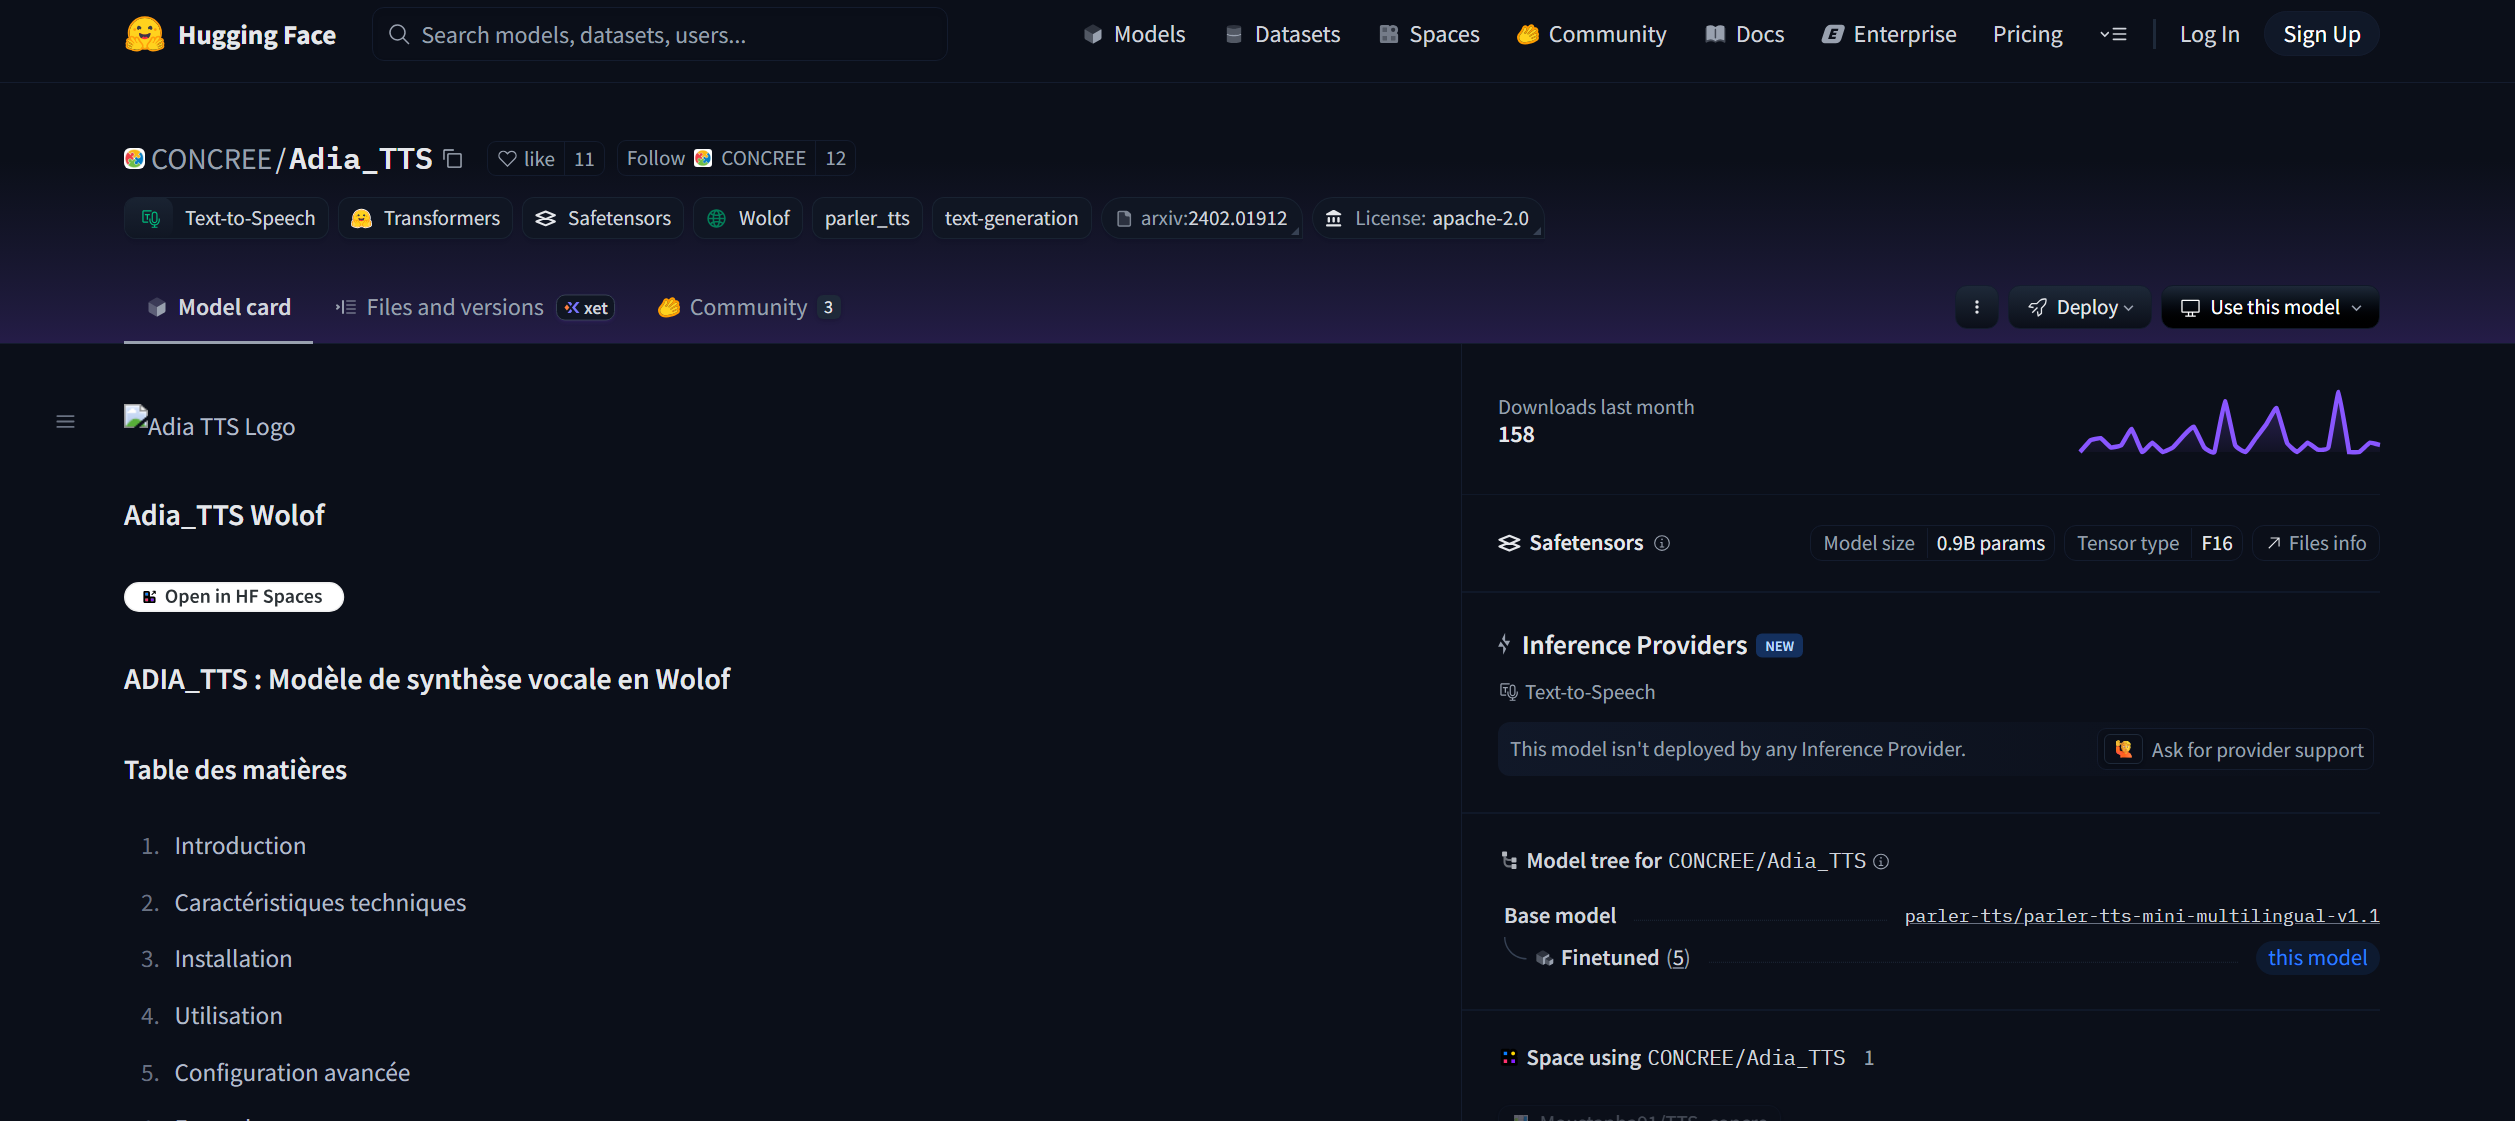

## 4.2 Techniques de Fine-tuning

### Full Fine-tuning
- Tous les paramètres
- ✓ Performance maximale
- ✗ Très coûteux

### LoRA (Low-Rank Adaptation)
- < 1% des paramètres
- ✓ Moins de mémoire
- ✓ Plus rapide
- ✗ Performance légèrement inférieure

### QLoRA (Quantized LoRA)
- Quantification 4-bit
- ✓ Encore moins de mémoire
- ✓ GPU grand public (RTX 3090)

---

## 4.3 Ressources Nécessaires

### Mémoire GPU (VRAM)

| Modèle | Full | LoRA | QLoRA |
|--------|------|------|-------|
| Llama-3-8B | 80GB+ | 24GB | 12GB |
| Mistral-7B | 80GB+ | 24GB | 12GB |
| Gemma-7B | 80GB+ | 24GB | 12GB |

### Données d'entraînement

| Tâche | Minimum | Optimal |
|-------|---------|---------|
| Classification | 100-500 | 1000+ |
| Q&A | 500-1000 | 5000+ |
| Traduction | 1000-5000 | 10000+ |

---

## 4.4 Datasets pour Langues Africaines

1. **FLORES-200** : Traduction (200 langues)
2. **AfriMTE** : Traduction africaine
3. **MasakhaNER** : NER (21 langues)
4. **AfriSenti** : Sentiment (14 langues)
5. **MAFAND** : Corpus multilingue
6. **JW300** : Textes religieux (300+ langues)

---

## 4.5 Initiatives Africaines en IA

1. **Masakhane** : NLP en langues africaines
2. **Deep Learning Indaba** : Conférence annuelle
3. **IndabaX** : Événements locaux
4. **AI4D Africa** : Recherche pour développement
5. **Zindi** : Compétitions data science
6. **Data Science Africa** : Réseau chercheurs

---

## 4.6 Feuille de Route pour la Guinée

### Phase 1 : Collecte de données
- Numériser textes Pular, Malinké, Soussou
- Collaborer avec linguistes
- Créer corpus de traduction
- Collecter textes oraux transcrits

### Phase 2 : Infrastructure
- Accès GPU cloud
- Configuration environnement
- Formation équipe

### Phase 3 : Expérimentation
- Fine-tuning modèles petits
- Tester LoRA, QLoRA
- Évaluation performances
- Itération

### Phase 4 : Déploiement
- Optimisation inférence
- Création API
- Applications pilotes
- Tests utilisateurs

---